[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//incubodac/GradCamTP/blob/main/GradCamV2.ipynb)

## Ejemplo oclusión

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


Target class id: 207


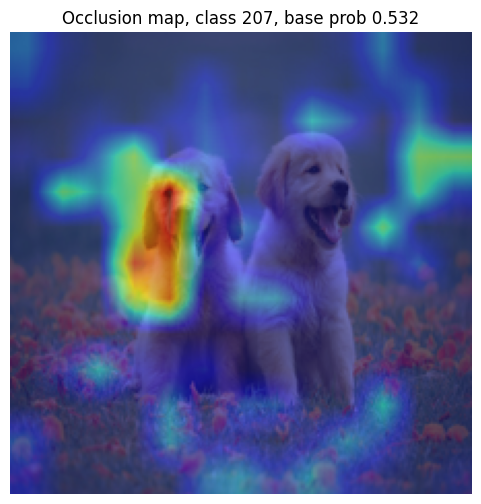

In [2]:
# Occlusion Map en PyTorch con una imagen de stock
# Requisitos: torch, torchvision, pillow, matplotlib, requests

import io
import math
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

# 1) Cargar imagen de stock
IMG_URL = "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg"  # perro de ejemplo
resp = requests.get(IMG_URL, timeout=10)
img = Image.open(io.BytesIO(resp.content)).convert("RGB")

# 2) Preprocesamiento para ResNet50
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
x = transform(img).unsqueeze(0)  # [1,3,224,224]

# 3) Modelo
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device).eval()

# 4) Clase objetivo: top 1
with torch.no_grad():
    logits = model(x.to(device))
    probs = logits.softmax(dim=1)
    target_class = probs.argmax(dim=1).item()
print("Target class id:", target_class)

# 5) Parámetros de oclusión
patch = 32        # tamaño del parche cuadrado
stride = 16       # desplazamiento
H = W = 224
baseline_rgb = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)  # color medio imagenet desnormalizado en espacio normalizado
baseline = baseline_rgb.to(device)

# 6) Función de score
def score_class(inp, cls):
    with torch.no_grad():
        return model(inp).softmax(dim=1)[0, cls].item()

# 7) Score original
base_score = score_class(x.to(device), target_class)

# 8) Barrido de oclusión
heat = torch.zeros((math.ceil((H - patch)/stride) + 1,
                    math.ceil((W - patch)/stride) + 1), dtype=torch.float32)

x_orig = x.to(device).clone()
for i, y0 in enumerate(range(0, H - patch + 1, stride)):
    for j, x0 in enumerate(range(0, W - patch + 1, stride)):
        x_occ = x_orig.clone()
        # reemplazo por baseline en espacio normalizado
        x_occ[:, :, y0:y0+patch, x0:x0+patch] = baseline
        s = score_class(x_occ, target_class)
        heat[i, j] = base_score - s  # caída en probabilidad

# 9) Normalizar y remapear a 224x224
heat_np = heat.clamp(min=0).cpu().numpy()
heat_np = heat_np / (heat_np.max() + 1e-8)
heat_img = Image.fromarray((heat_np * 255).astype(np.uint8)).resize((W, H), resample=Image.BILINEAR)
heat_img = np.array(heat_img) / 255.0

# 10) Visualización
plt.figure(figsize=(6,6))
plt.imshow(img.resize((W, H)))
plt.imshow(heat_img, alpha=0.5, cmap="jet")
plt.axis("off")
plt.title(f"Occlusion map, class {target_class}, base prob {base_score:.3f}")
plt.show()

# Notas:
# - Ajusta patch y stride para intercambiar resolución por costo computacional.
# - Puedes usar caída en logit en lugar de probabilidad, cambiando score_class por el logit sin softmax.
# - baseline se puede reemplazar por desenfoque o el promedio local para reducir artefactos de borde.


---
---
# VIEJO


# GradCAM: Gradient-weighted Class Activation Mapping

## Introducción al Método GradCAM

**GradCAM (Gradient-weighted Class Activation Mapping)** es una técnica de explicabilidad de redes neuronales convolucionales (CNN) que mejora significativamente el método CAM (Class Activation Mapping) original. Esta metodología permite generar mapas de calor que muestran las regiones de una imagen que fueron más importantes para la predicción de una clase específica.

## Evolución desde CAM hacia GradCAM

### Limitaciones del CAM Original:
- **Restricción arquitectónica**: Requería modificar la arquitectura de la CNN, añadiendo una capa de Global Average Pooling (GAP) seguida de una capa completamente conectada
- **Limitación de aplicabilidad**: Solo funcionaba con arquitecturas específicamente diseñadas para CAM
- **Pérdida de generalidad**: No se podía aplicar a modelos pre-entrenados existentes

### Ventajas de GradCAM:
- **Generalidad**: Funciona con cualquier arquitectura CNN sin modificaciones
- **Flexibilidad**: Se puede aplicar a modelos pre-entrenados
- **Precisión**: Proporciona localizaciones más precisas de las características importantes

## Fundamentos Matemáticos de GradCAM

### 1. Cálculo de los Gradientes

Para una clase objetivo $c$ y una capa convolucional específica, calculamos los gradientes de la puntuación de clase $y^c$ con respecto a los mapas de características $A^k$:

$$\frac{\partial y^c}{\partial A_{i,j}^k}$$

donde:
- $y^c$ es la puntuación para la clase $c$ (antes de softmax)
- $A_{i,j}^k$ es la activación en la posición $(i,j)$ del mapa de características $k$

### 2. Pesos de Importancia por Gradiente Global

Los pesos de importancia $\alpha_k^c$ para cada mapa de características $k$ se calculan mediante la agregación global de los gradientes:

$$\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{i,j}^k}$$

donde $Z$ es el número total de píxeles en el mapa de características ($Z = width \times height$).

Esta operación equivale a un **Global Average Pooling** sobre los gradientes, capturando la importancia de cada canal de características para la predicción de la clase $c$.

### 3. Mapa de Localización GradCAM

El mapa de localización GradCAM $L_{GradCAM}^c$ se obtiene mediante la combinación lineal ponderada de los mapas de características, seguida de una función ReLU:

$$L_{GradCAM}^c = ReLU\left(\sum_k \alpha_k^c A^k\right)$$

La función ReLU se aplica porque solo nos interesan las características que tienen una **influencia positiva** en la clase de interés.

### 4. Normalización y Visualización

Finalmente, el mapa se normaliza al rango [0,1] para la visualización:

$$L_{GradCAM}^c = \frac{L_{GradCAM}^c - \min(L_{GradCAM}^c)}{\max(L_{GradCAM}^c) - \min(L_{GradCAM}^c)}$$

## Interpretación Física del Método

1. **Propagación hacia adelante**: La imagen pasa por la CNN hasta generar la predicción
2. **Propagación hacia atrás**: Los gradientes fluyen desde la neurona de clase objetivo hasta la capa convolucional de interés
3. **Agregación espacial**: Los gradientes se promedian espacialmente para obtener la importancia de cada canal
4. **Combinación ponderada**: Los mapas de características se combinan usando estos pesos de importancia
5. **Activación positiva**: Solo se conservan las influencias positivas mediante ReLU

## Ventajas Técnicas de GradCAM

- ✅ **Independiente de la arquitectura**: Funciona con ResNet, VGG, Inception, etc.
- ✅ **Aplicable a modelos existentes**: No requiere reentrenamiento
- ✅ **Computacionalmente eficiente**: Solo requiere una pasada hacia adelante y hacia atrás
- ✅ **Resolución espacial preservada**: Mantiene información de localización espacial
- ✅ **Interpretabilidad intuitiva**: Los mapas de calor son fáciles de interpretar

---

*Este notebook implementa GradCAM usando PyTorch y la biblioteca `pytorch-grad-cam` para analizar modelos de clasificación de imágenes.*

In [ ]:
%%capture
# Install required packages
import subprocess
import sys

packages = [
    "grad-cam",
    "torch",
    "torchvision",
    "matplotlib",
    "numpy",
    "opencv-python",
    "Pillow"
]

for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("All packages installed successfully!")

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad,FinerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import torchvision
from PIL import Image
import numpy as np

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
# open an image file
image = Image.open("cat_and_dog2.jpg")
image = image.convert("RGB")
image = image.resize((224, 224))

# Convert PIL image to numpy array and normalize to [0, 1]
rgb_img = np.float32(image) / 255

input_tensor = torchvision.transforms.ToTensor()(image).unsqueeze(0)
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(246)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!pip install grad-cam torch torchvision matplotlib numpy opencv-python Pillow

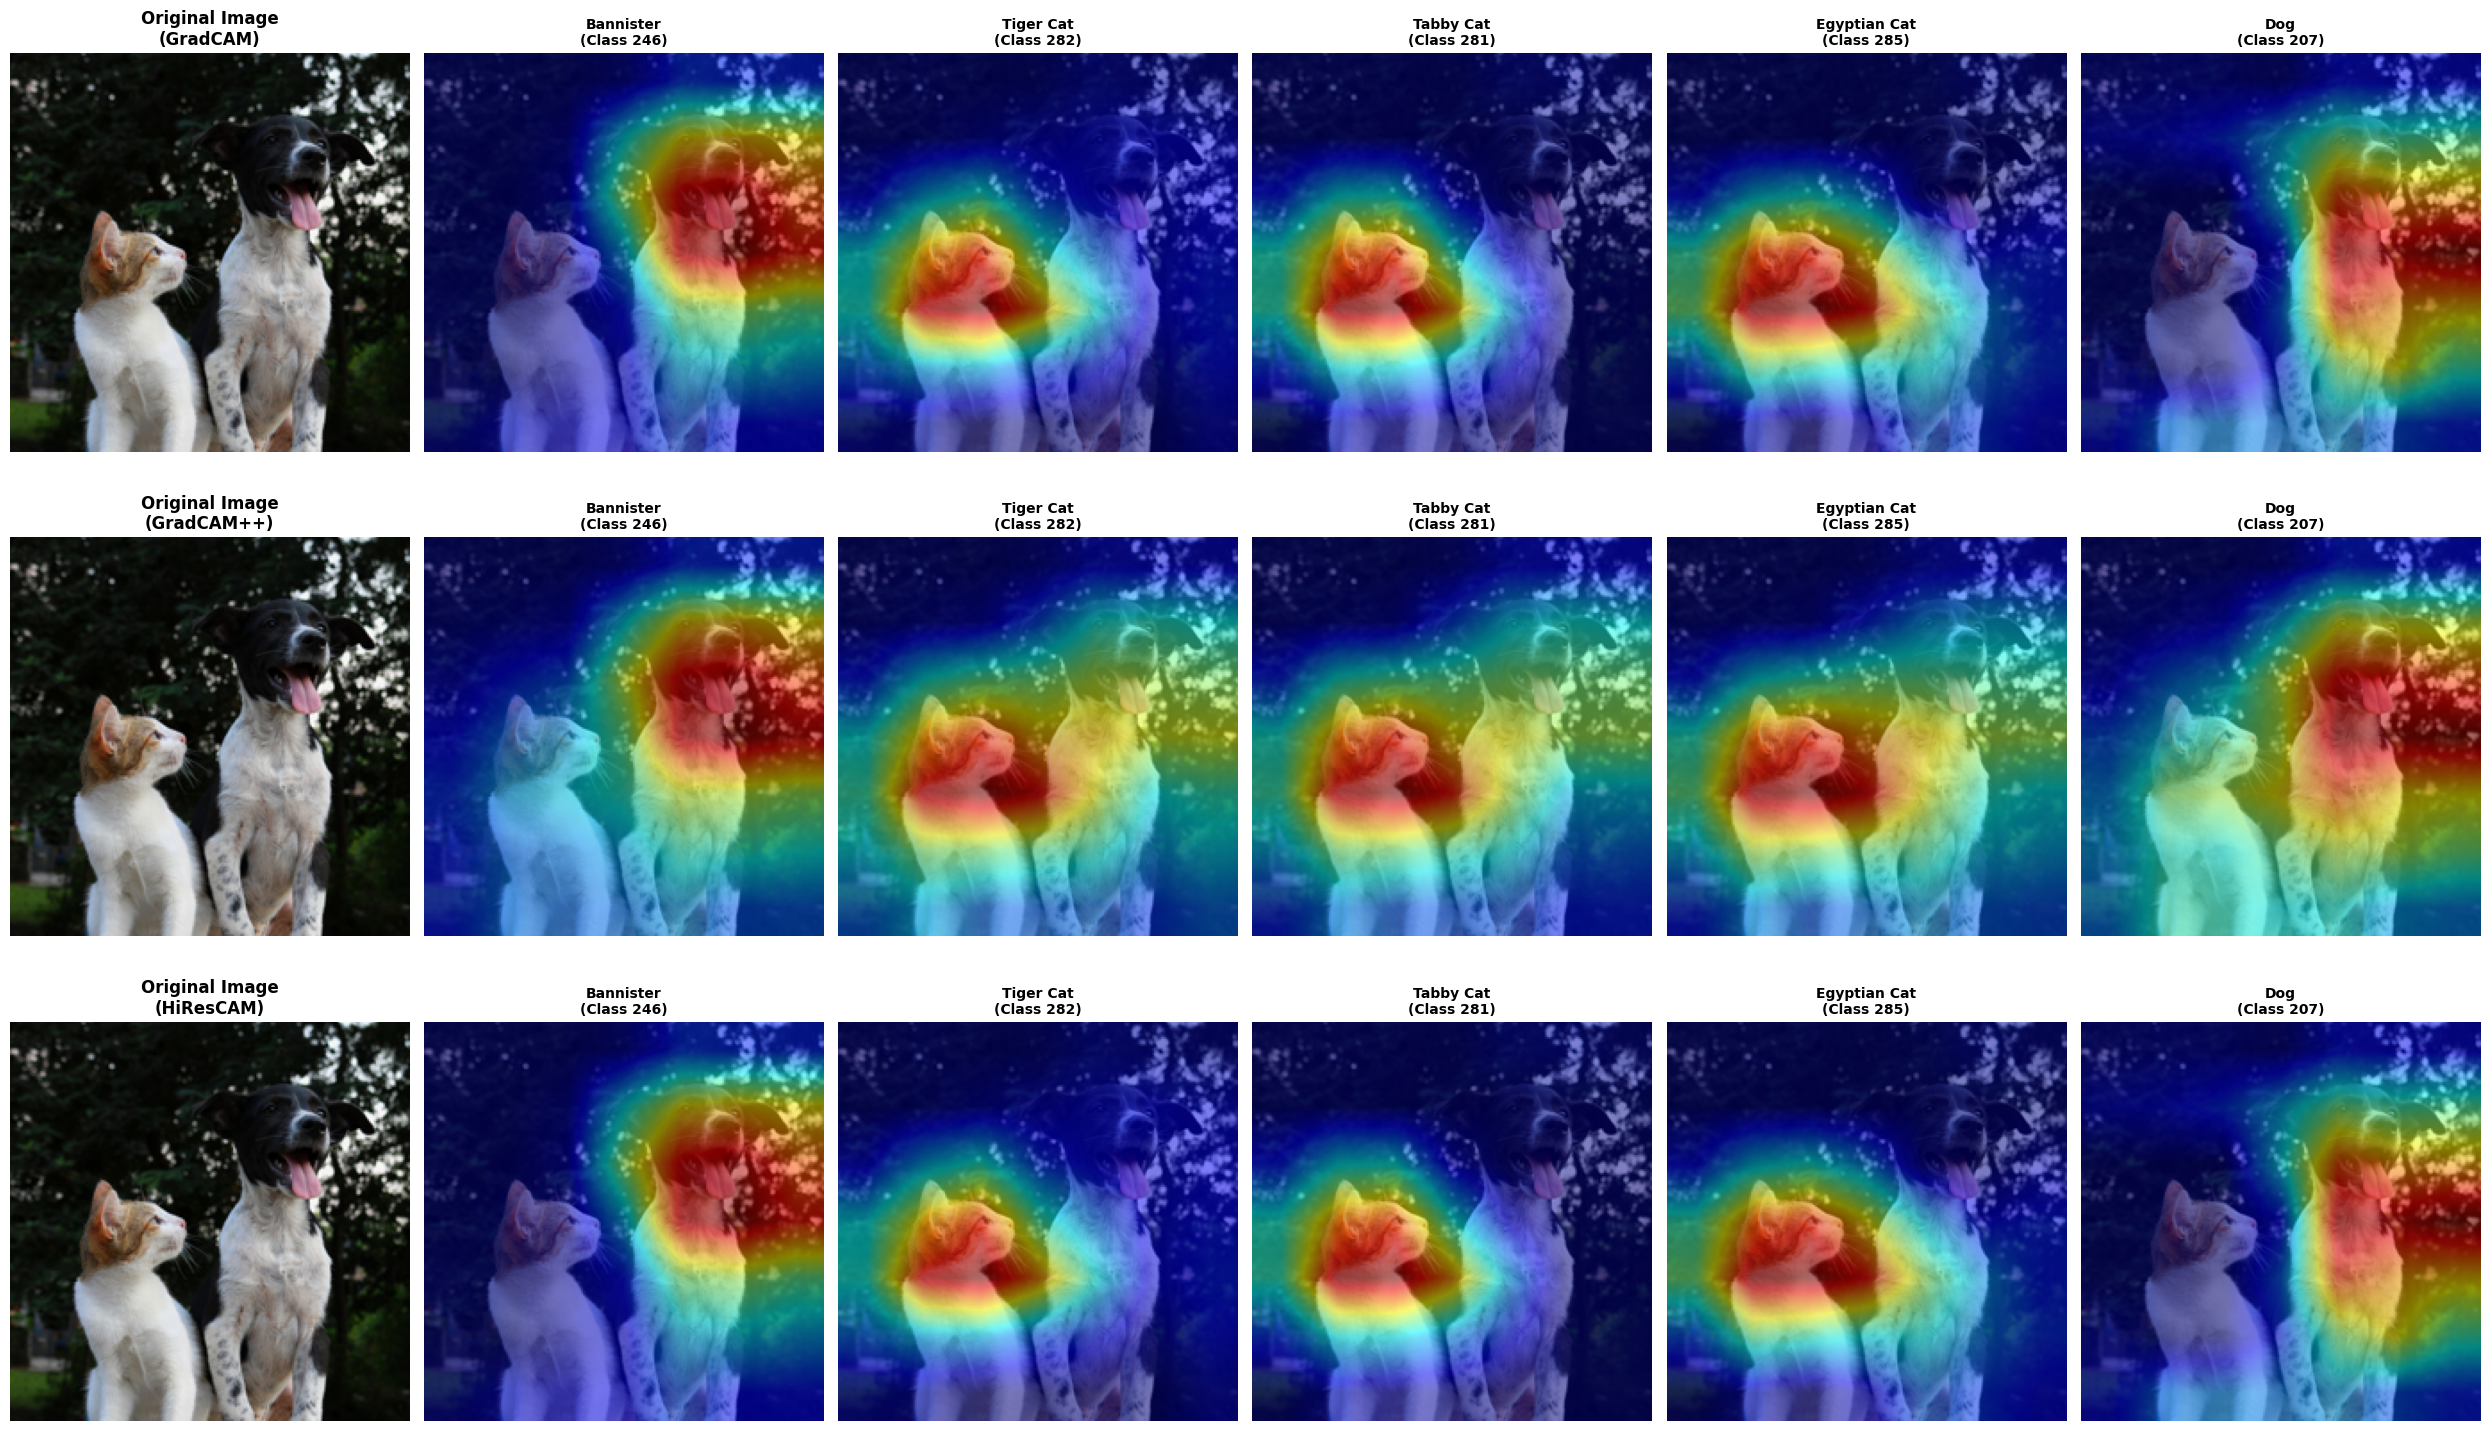

Model Predictions for Each Target Class:
Bannister       (Class 246): 0.308459 (30.8459%)
Tiger Cat       (Class 282): 0.002888 (0.2888%)
Tabby Cat       (Class 281): 0.001201 (0.1201%)
Egyptian Cat    (Class 285): 0.029394 (2.9394%)
Dog             (Class 207): 0.000708 (0.0708%)

Actual predicted class: 246
Highest probability: 0.308459 (30.8459%)

CAM Methods Compared:
Row 1: GradCAM
Row 2: GradCAM++
Row 3: HiResCAM

Classes Compared:
Column 2: Bannister (Class 246)
Column 3: Tiger Cat (Class 282)
Column 4: Tabby Cat (Class 281)
Column 5: Egyptian Cat (Class 285)
Column 6: Dog (Class 207)


In [ ]:
# Compare visualizations for different target classes and CAM methods
import matplotlib.pyplot as plt

# Initialize different CAM methods (excluding FinerCAM to avoid context manager issues)
cam_methods = {
    'GradCAM': GradCAM(model=model, target_layers=target_layers),
    'GradCAM++': GradCAMPlusPlus(model=model, target_layers=target_layers),
    'HiResCAM': HiResCAM(model=model, target_layers=target_layers),
}

# Define different target classes (ImageNet class indices)
target_classes = {
    'Bannister': 246,  # Original class you were using
    'Tiger Cat': 282,  # Tiger cat class
    'Tabby Cat': 281,  # Tabby cat class
    'Egyptian Cat': 285,  # Egyptian cat class
    'Dog': 207,  # Generic dog class
}

# Generate visualizations for each method and each target class
method_class_visualizations = {}

for method_name, cam_instance in cam_methods.items():
    method_class_visualizations[method_name] = {}

    with cam_instance:
        for class_name, class_idx in target_classes.items():
            targets_class = [ClassifierOutputTarget(class_idx)]
            grayscale_cam = cam_instance(input_tensor=input_tensor, targets=targets_class)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            method_class_visualizations[method_name][class_name] = visualization

# Create the visualization grid: Each row = one method, Each column = one class
num_methods = len(cam_methods)
num_classes = len(target_classes)
plt.figure(figsize=(25, 15))

# Display grid: rows = methods, columns = original + classes
for row, (method_name, class_visualizations) in enumerate(method_class_visualizations.items()):
    # First column: Original image for each row
    plt.subplot(num_methods, num_classes + 1, row * (num_classes + 1) + 1)
    plt.imshow(rgb_img)
    plt.title(f'Original Image\n({method_name})', fontsize=12, fontweight='bold')
    plt.axis('off')

    # Remaining columns: Class-specific visualizations
    for col, (class_name, visualization) in enumerate(class_visualizations.items(), 2):
        plt.subplot(num_methods, num_classes + 1, row * (num_classes + 1) + col)
        plt.imshow(visualization)
        plt.title(f'{class_name}\n(Class {target_classes[class_name]})', fontsize=10, fontweight='bold')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Show model predictions for each target class
print("Model Predictions for Each Target Class:")
print("=" * 60)
probabilities = F.softmax(model_outputs, dim=1)

for class_name, class_idx in target_classes.items():
    prob = probabilities[0][class_idx].item()
    print(f"{class_name:15} (Class {class_idx:3}): {prob:.6f} ({prob*100:.4f}%)")

print(f"\nActual predicted class: {probabilities[0].argmax().item()}")
print(f"Highest probability: {probabilities[0].max().item():.6f} ({probabilities[0].max().item()*100:.4f}%)")

# Show which CAM methods were used
print(f"\nCAM Methods Compared:")
for i, method_name in enumerate(cam_methods.keys(), 1):
    print(f"Row {i}: {method_name}")
print(f"\nClasses Compared:")
for i, (class_name, class_idx) in enumerate(target_classes.items(), 1):
    print(f"Column {i+1}: {class_name} (Class {class_idx})")